# *Depreciated, expect us to come up with other examples that allows this*

## Minimal Example on merging LoRA with LoRA, and applying it to single model.

This notebook demonstrates how to merge two LoRA models, and apply the merged model to a single model.
i.e.,

$$
W \leftarrow W + (A_1 \alpha + A_2 \beta)(B_1 \alpha + B_2 \beta)^T
$$

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

/home/simo/anaconda3/envs/pytorch_latest/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

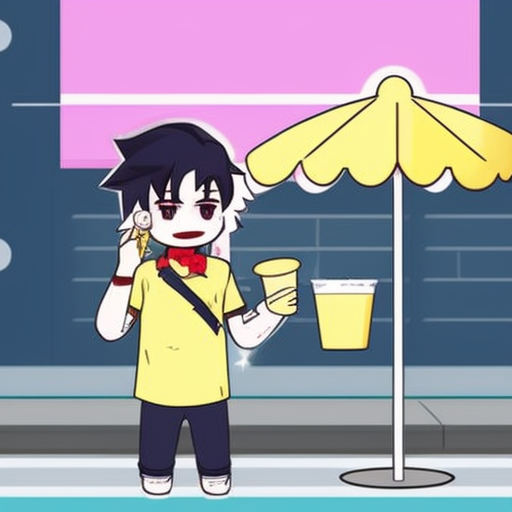

In [11]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda:1"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

prompt = "game character bnha, selling cup of lemonade on the street, vector illustration"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=30, guidance_scale=7).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

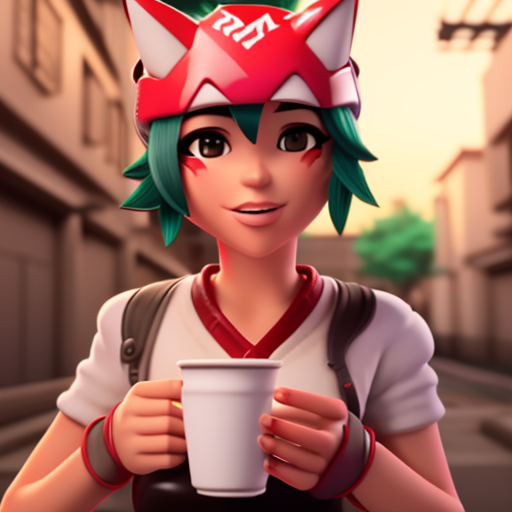

In [12]:
from lora_diffusion import monkeypatch_lora, tune_lora_scale, monkeypatch_add_lora


monkeypatch_lora(pipe.unet, torch.load("../lora_kiriko.pt"))
monkeypatch_lora(pipe.text_encoder, torch.load("../lora_kiriko.text_encoder.pt"), target_replace_module=["CLIPAttention"])
tune_lora_scale(pipe.unet, 1.00)

torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=30, guidance_scale=7).images[0]
image.save("../contents/lora_with_clip.jpg")
image # Clearly overfitting.

  0%|          | 0/30 [00:00<?, ?it/s]

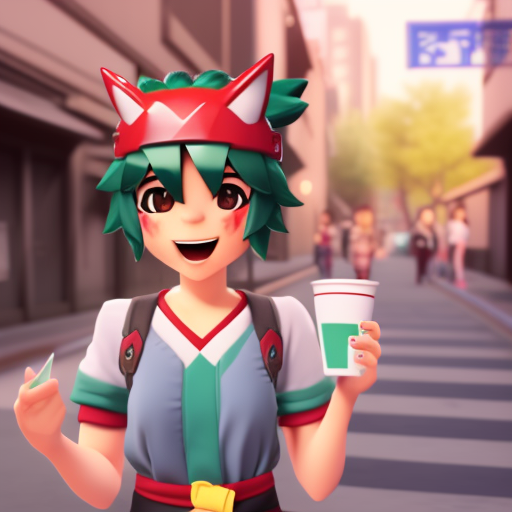

In [13]:
torch.manual_seed(0)
tune_lora_scale(pipe.unet, 0.7)
tune_lora_scale(pipe.text_encoder, 0.7)
image = pipe(prompt, num_inference_steps=30, guidance_scale=7).images[0]
image # Bit better.

Now, that is

$$
W \leftarrow W + 0.7 A_1 B_1^T
$$
applied dynamically.
Anyways, let's try adding another lora onto it. We want to make it "illusty", so we will add an illustration LoRA.
So we will take the illustration lora $A_2$, $B_2$ and merge it with $A_1$, $B_1$ with $\alpha = 1.0$ and $\beta = 1.0$.
Then we will apply the merged model to the single model.
i.e.,

$$
W \leftarrow W + (A_1 + A_2)(B_1 + B_2)^T
$$

  0%|          | 0/30 [00:00<?, ?it/s]

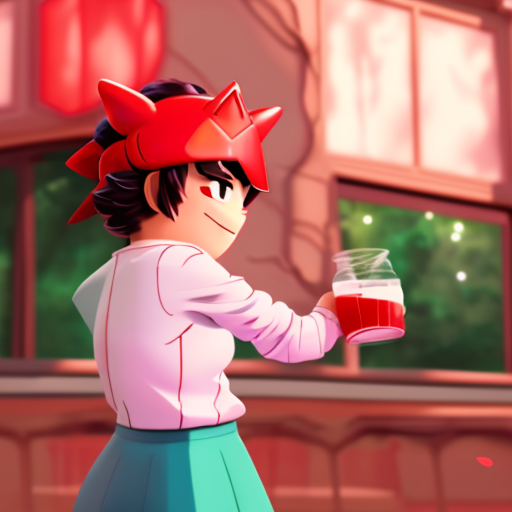

In [14]:
torch.manual_seed(0)

monkeypatch_add_lora(pipe.unet, torch.load("../lora_illust.pt"), alpha=1.0, beta = 1.0)
tune_lora_scale(pipe.unet, 0.7)
tune_lora_scale(pipe.text_encoder, 0.7)

image = pipe(prompt, num_inference_steps=30, guidance_scale=7).images[0]
image

Now since that is overfitted again, we will tone down a bit, once more.

  0%|          | 0/30 [00:00<?, ?it/s]

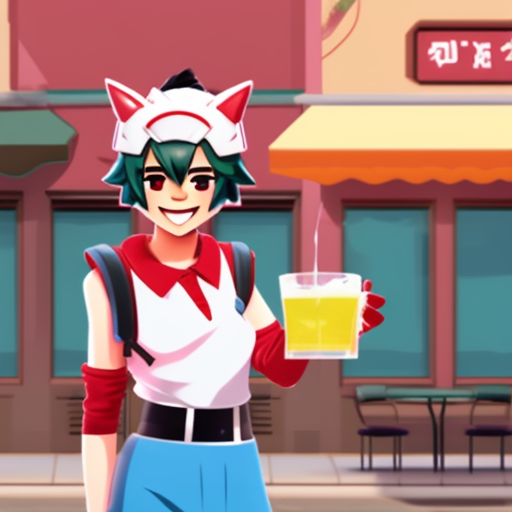

In [15]:
torch.manual_seed(0)
tune_lora_scale(pipe.unet, 0.5)
tune_lora_scale(pipe.text_encoder, 0.5)

image = pipe(prompt, num_inference_steps=30, guidance_scale=7).images[0]
image

So that is both "illustration-like" and "Kiriko-like".
Since we've only merged Unet Lora, above result is:

$$
W_{unet} \leftarrow W_{unet} + 0.5 (A_{kiriko} + A_{illust})(B_{kiriko} + B_{illust})^T
$$

and

$$
W_{clip} \leftarrow W_{clip} + 0.5 A_{kiriko}B_{kiriko}^T
$$

In [16]:
image.save("../contents/lora_with_clip_and_illust.jpg")